In [1]:
import sys
sys.path.append('../src')

from collections import Counter
import localmodule
import functools
from joblib import Memory, Parallel, delayed
from librosa.display import specshow
import math
import music21 as m21
import numpy as np
import os
import scipy

In [6]:
# Define constants.
J_tm = 9
N = 2**10
n_octaves = 8
midi_octave_offset = 2
quantization = 2.0
xi = 0.4
sigma = 0.16

midis = []

pianoroll = np.zeros((n_octaves*12, N))
pianoroll[n_octaves*6, int(N/2)] = 1.0

# Setup wavelet filter bank over time.
wavelet_filterbank_ft = np.zeros((1, N, J_tm))
for j in range(J_tm-1):
    xi_j = xi * 2**(-j)
    sigma_j = sigma * 2**(-j)
    center = xi_j * N
    den = 2 * sigma_j * sigma_j * N * N
    psi_ft = localmodule.morlet(center, den, N, n_periods=4)
    conj_psi_ft = np.roll(psi_ft, -1)[::-1]
    wavelet_filterbank_ft[0, :, -1 - j] = psi_ft
    
# Append scaling function phi (average).
wavelet_filterbank_ft[0, 0, 0] = 1

# Convolve pianoroll with filterbank.
pianoroll_ft = scipy.fftpack.fft(pianoroll, axis=1)
pianoroll_ft = np.expand_dims(pianoroll_ft, axis=2)
wavelet_transform_ft = pianoroll_ft * wavelet_filterbank_ft
wavelet_transform = scipy.fftpack.ifft(wavelet_transform_ft, axis=1)


# Reshape MIDI axis to chromagram
chromagram = np.reshape(wavelet_transform,
    (12, -1, wavelet_transform.shape[1], wavelet_transform.shape[2]), 'F')


# Construct eigentriads
cosine_basis = np.array([[np.cos(2*np.pi*omega*t/3) for omega in range(3)] for t in range(3)]).T
sine_basis = np.array([[np.sin(2*np.pi*omega*t/3) for omega in range(3)] for t in range(3)]).T
fourier_basis = cosine_basis + np.complex(0, 1) * sine_basis
major_template = [0, 4, 7]
minor_template = [0, 3, 7]
major_eigentriads = np.zeros((12, 3), dtype=np.complex)
minor_eigentriads = np.zeros((12, 3), dtype=np.complex)
for omega in range(3):
    for t, p in enumerate(major_template):
        major_eigentriads[p, omega] = fourier_basis[t, omega]
    for t, p in enumerate(minor_template):
        minor_eigentriads[p, omega] = fourier_basis[t, omega]
eigentriads = np.stack(
    (major_eigentriads, minor_eigentriads), axis=1)

# Convolve chromagram with eigentriads
chromagram_ft = scipy.fftpack.fft(chromagram, axis=0)
chromagram_ft = chromagram_ft[:, np.newaxis, :, :, :, np.newaxis]
eigentriads_ft = scipy.fftpack.fft(eigentriads, axis=0)
eigentriads_ft = eigentriads_ft[:, :, np.newaxis,
    np.newaxis, np.newaxis, :]
eigentriad_transform_ft = chromagram_ft * eigentriads_ft
eigentriad_transform = scipy.fftpack.fft(
    eigentriad_transform_ft, axis=0)

In [21]:
X = np.transpose(eigentriad_transform, (1, 0, 2, 3, 4, 5))
X = np.reshape(X, (X.shape[0], X.shape[1]*X.shape[2], X.shape[3], X.shape[4], X.shape[5]),
    order='F')

print(X.shape)

(2, 96, 1024, 9, 3)


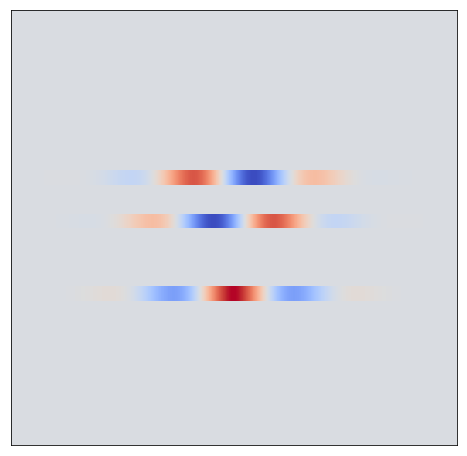

In [50]:
%matplotlib inline
from matplotlib import pyplot as plt
from librosa.display import specshow

plt.figure(figsize=(8, 8))
specshow(np.real(X[0, 38:68, :, 1, 1]))

plt.savefig('eigentriad.eps')
plt.savefig('eigentriad.png')

In [40]:
96/2 - 10

38.0